<a href="https://colab.research.google.com/github/PrintfPeng/Allforone/blob/main/model2_Durian.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [ ]:
from google.colab import drive
drive.mount('/content/drive')


Mounted at /content/drive


In [ ]:
DATASET_ZIP = "/content/drive/MyDrive/dataset.zip"  # << ใช้พาธของคุณ

!rm -rf "/content/dataset_model2"
!mkdir -p "/content/dataset_model2"
!unzip -oq "$DATASET_ZIP" -d "/content/dataset_model2"

# ดูโครงสร้างชั้นบน ๆ
!find /content/dataset_model2 -maxdepth 2 -type d -print | sed 's|/content||'


/dataset_model2
/dataset_model2/dataset
/dataset_model2/dataset/test
/dataset_model2/dataset/train
/dataset_model2/dataset/val


In [ ]:
from pathlib import Path

BASE = Path("/content/dataset_model2")
train_cands = sorted([p for p in BASE.rglob("train") if p.is_dir()])
test_cands  = sorted([p for p in BASE.rglob("test")  if p.is_dir()])

def is_valid_split(p: Path, min_classes=2):
    return sum(1 for d in p.iterdir() if d.is_dir()) >= min_classes

train_dir = next((p for p in train_cands if is_valid_split(p)), None)
test_dir  = None
if train_dir:
    sib = train_dir.parent / "test"
    test_dir = sib if sib.exists() and sib.is_dir() else None
if test_dir is None:
    test_dir = next((p for p in test_cands if is_valid_split(p, 1)), None)

print("Train dir:", train_dir)
print("Test  dir:", test_dir)
assert train_dir is not None and test_dir is not None, "❌ ไม่พบโฟลเดอร์ train/test ใน zip — ตรวจไฟล์อีกครั้ง"

# รายชื่อคลาส + จำนวนภาพใน train
from collections import defaultdict
exts = {".jpg",".jpeg",".png",".bmp",".webp"}
cls_names = sorted([d.name for d in train_dir.iterdir() if d.is_dir()])
print("Classes:", cls_names)

def count_images(folder: Path):
    return sum(1 for p in folder.rglob("*") if p.suffix.lower() in exts)

print("Image counts (train):")
for c in cls_names:
    print(f"  {c:24s} {count_images(train_dir / c):5d}")


Train dir: /content/dataset_model2/dataset/train
Test  dir: /content/dataset_model2/dataset/test
Classes: ['ALGAL_LEAF_SPOT', 'HEALTHY_LEAF', 'LEAF_BLIGHT', 'PHOMOPSIS_LEAF_SPOT']
Image counts (train):
  ALGAL_LEAF_SPOT            513
  HEALTHY_LEAF               683
  LEAF_BLIGHT                655
  PHOMOPSIS_LEAF_SPOT        614


In [ ]:
import tensorflow as tf
from tensorflow import keras
from tensorflow.keras.preprocessing.image import ImageDataGenerator

train_gen_2 = ImageDataGenerator(
    rotation_range=15, width_shift_range=0.05, height_shift_range=0.05,
    shear_range=0.05, zoom_range=0.10, horizontal_flip=True, fill_mode="nearest"
)
valid_gen_2 = ImageDataGenerator()  # no augmentation/rescale

train_data_2 = train_gen_2.flow_from_directory(
    str(train_dir), target_size=(299,299), batch_size=32,
    class_mode="categorical", shuffle=True, seed=42
)
valid_data_2 = valid_gen_2.flow_from_directory(
    str(test_dir), target_size=(299,299), batch_size=32,
    class_mode="categorical", shuffle=False
)

NUM_CLASSES_2 = train_data_2.num_classes
class_indices_2 = train_data_2.class_indices
idx2name_2 = {v:k for k,v in class_indices_2.items()}
print("Class mapping (Model 2):", class_indices_2)


Found 2465 images belonging to 4 classes.
Found 1157 images belonging to 4 classes.
Class mapping (Model 2): {'ALGAL_LEAF_SPOT': 0, 'HEALTHY_LEAF': 1, 'LEAF_BLIGHT': 2, 'PHOMOPSIS_LEAF_SPOT': 3}


83683744/83683744 ━━━━━━━━━━━━━━━━━━━━ 0s 0us/step


Model: "xception_model_2"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ input_layer_1 (InputLayer)      │ (None, 299, 299, 3)    │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ lambda (Lambda)                 │ (None, 299, 299, 3)    │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ xception (Functional)           │ (None, 10, 10, 2048)   │    20,861,480 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ global_average_pooling2d        │ (None, 2048)           │             0 │
│ (GlobalAveragePooling2D)        │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout (Dropout)               │ (None, 2048)           │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense (Dense)                   │ (None, 4)              │         8,196 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 20,869,676 (79.61 MB)

 Trainable params: 8,196 (32.02 KB)

 Non-trainable params: 20,861,480 (79.58 MB)

/usr/local/lib/python3.12/dist-packages/keras/src/trainers/data_adapters/py_dataset_adapter.py:121: UserWarning: Your `PyDataset` class should call `super().__init__(**kwargs)` in its constructor. `**kwargs` can include `workers`, `use_multiprocessing`, `max_queue_size`. Do not pass these arguments to `fit()`, as they will be ignored.
  self._warn_if_super_not_called()


Epoch 1/5
78/78 ━━━━━━━━━━━━━━━━━━━━ 149s 1s/step - accuracy: 0.3475 - loss: 1.3389 - val_accuracy: 0.4036 - val_loss: 1.2454 - learning_rate: 0.0010
Epoch 2/5
78/78 ━━━━━━━━━━━━━━━━━━━━ 64s 821ms/step - accuracy: 0.5245 - loss: 1.1324 - val_accuracy: 0.4494 - val_loss: 1.2086 - learning_rate: 0.0010
Epoch 3/5
78/78 ━━━━━━━━━━━━━━━━━━━━ 64s 821ms/step - accuracy: 0.5643 - loss: 1.0449 - val_accuracy: 0.4633 - val_loss: 1.1725 - learning_rate: 0.0010
Epoch 4/5
78/78 ━━━━━━━━━━━━━━━━━━━━ 64s 823ms/step - accuracy: 0.5972 - loss: 0.9889 - val_accuracy: 0.5385 - val_loss: 1.0655 - learning_rate: 0.0010
Epoch 5/5
78/78 ━━━━━━━━━━━━━━━━━━━━ 66s 844ms/step - accuracy: 0.5948 - loss: 0.9735 - val_accuracy: 0.5696 - val_loss: 1.0108 - learning_rate: 0.0010
Epoch 1/10
78/78 ━━━━━━━━━━━━━━━━━━━━ 156s 2s/step - accuracy: 0.5568 - loss: 1.0360 - val_accuracy: 0.7744 - val_loss: 0.5851 - learning_rate: 1.0000e-04
Epoch 2/10
78/78 ━━━━━━━━━━━━━━━━━━━━ 70s 898ms/step - accuracy: 0.8396 - loss: 0.4306 

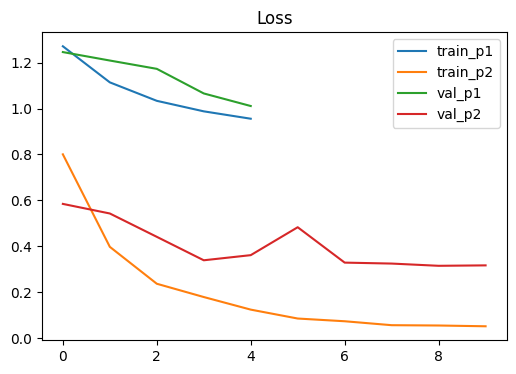

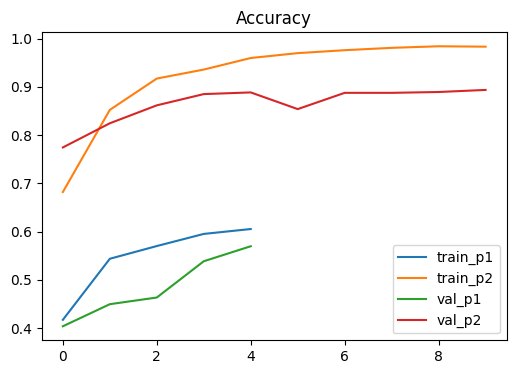

[Model 2] Validation - loss: 0.3159  acc: 0.8894
37/37 ━━━━━━━━━━━━━━━━━━━━ 32s 556ms/step
                     precision    recall  f1-score   support

    ALGAL_LEAF_SPOT     0.7957    0.8618    0.8274       217
       HEALTHY_LEAF     0.8960    0.8358    0.8649       268
        LEAF_BLIGHT     0.9648    0.9395    0.9520       496
PHOMOPSIS_LEAF_SPOT     0.8042    0.8636    0.8329       176

           accuracy                         0.8894      1157
          macro avg     0.8652    0.8752    0.8693      1157
       weighted avg     0.8927    0.8894    0.8903      1157



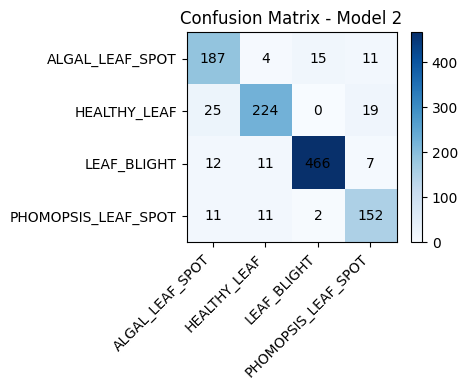

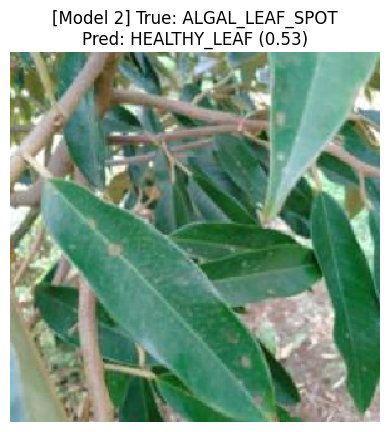

Class order (Model 2): ['ALGAL_LEAF_SPOT', 'HEALTHY_LEAF', 'LEAF_BLIGHT', 'PHOMOPSIS_LEAF_SPOT']
ALGAL_LEAF_SPOT        : 0.456
HEALTHY_LEAF           : 0.528
LEAF_BLIGHT            : 0.005
PHOMOPSIS_LEAF_SPOT    : 0.010


In [ ]:
import matplotlib.pyplot as plt
from tensorflow.keras.applications import Xception
from tensorflow.keras.applications.xception import preprocess_input
from tensorflow.keras.callbacks import EarlyStopping, ReduceLROnPlateau, ModelCheckpoint
from sklearn.metrics import classification_report, confusion_matrix
import numpy as np, random, os

tf.random.set_seed(42)

# ----- Build -----
base_2 = Xception(include_top=False, weights="imagenet", input_shape=(299,299,3))
base_2.trainable = False  # Phase 1: freeze

inputs_2 = keras.Input(shape=(299,299,3))
x = keras.layers.Lambda(preprocess_input)(inputs_2)
x = base_2(x, training=False)
x = keras.layers.GlobalAveragePooling2D()(x)
x = keras.layers.Dropout(0.3)(x)
outputs_2 = keras.layers.Dense(NUM_CLASSES_2, activation="softmax")(x)
model_2 = keras.Model(inputs_2, outputs_2, name="xception_model_2")

model_2.compile(optimizer=keras.optimizers.Adam(1e-3),
                loss="categorical_crossentropy", metrics=["accuracy"])
model_2.summary()

# ----- Callbacks -----
ckpt_path_2 = "/content/model_2_xception_best.keras"
early_stop_2 = EarlyStopping(monitor="val_loss", patience=3, restore_best_weights=True)
reduce_lr_2  = ReduceLROnPlateau(monitor="val_loss", factor=0.1, patience=2)
save_best_2  = ModelCheckpoint(ckpt_path_2, monitor="val_loss", save_best_only=True)

# ----- Train: Phase 1 (Frozen) -----
history_2_phase1 = model_2.fit(
    train_data_2, epochs=5, validation_data=valid_data_2,
    callbacks=[early_stop_2, reduce_lr_2, save_best_2]
)

# ----- Train: Phase 2 (Fine-tune last ~40 layers) -----
base_2.trainable = True
for layer in base_2.layers[:-40]:
    layer.trainable = False

model_2.compile(optimizer=keras.optimizers.Adam(1e-4),
                loss="categorical_crossentropy", metrics=["accuracy"])

history_2_phase2 = model_2.fit(
    train_data_2, epochs=10, validation_data=valid_data_2,
    callbacks=[early_stop_2, reduce_lr_2, save_best_2]
)

# ----- Curves -----
def plot_curve(hlist, key):
    plt.figure(figsize=(6,4))
    for h in hlist: plt.plot(h.history[key])
    for h in hlist: plt.plot(h.history["val_"+key])
    plt.title(key.capitalize())
    plt.legend([f"train_p{i+1}" for i in range(len(hlist))] +
               [f"val_p{i+1}" for i in range(len(hlist))])
    plt.show()

plot_curve([history_2_phase1, history_2_phase2], "loss")
plot_curve([history_2_phase1, history_2_phase2], "accuracy")

# ----- Evaluate & Report -----
val_loss_2, val_acc_2 = model_2.evaluate(valid_data_2, verbose=0)
print(f"[Model 2] Validation - loss: {val_loss_2:.4f}  acc: {val_acc_2:.4f}")

pred_probs_2 = model_2.predict(valid_data_2, verbose=1)
y_pred_2 = np.argmax(pred_probs_2, axis=1)
y_true_2 = valid_data_2.classes
target_names_2 = [idx2name_2[i] for i in range(NUM_CLASSES_2)]

print(classification_report(y_true_2, y_pred_2, target_names=target_names_2, digits=4))

cm_2 = confusion_matrix(y_true_2, y_pred_2)
plt.figure(figsize=(5,4))
plt.imshow(cm_2, cmap="Blues"); plt.title("Confusion Matrix - Model 2"); plt.colorbar()
plt.xticks(range(NUM_CLASSES_2), target_names_2, rotation=45, ha="right")
plt.yticks(range(NUM_CLASSES_2), target_names_2)
for i in range(NUM_CLASSES_2):
    for j in range(NUM_CLASSES_2):
        plt.text(j, i, cm_2[i, j], ha="center", va="center")
plt.tight_layout(); plt.show()

# ----- Predict helper (สุ่มภาพหนึ่งจาก test) -----
from tensorflow.keras.preprocessing import image

def random_image_path(root):
    class_dirs = [d for d in os.listdir(root) if os.path.isdir(os.path.join(root, d))]
    cls = random.choice(sorted(class_dirs))
    files = [f for f in os.listdir(os.path.join(root, cls))
             if f.lower().endswith((".jpg",".jpeg",".png",".bmp",".webp"))]
    img_name = random.choice(files)
    return os.path.join(root, cls, img_name), cls

def predict_one_2(img_path):
    img = image.load_img(img_path, target_size=(299,299))
    x = image.img_to_array(img)
    x = np.expand_dims(x, axis=0)
    x = preprocess_input(x)
    probs = model_2.predict(x, verbose=0)[0]
    pred_idx = int(np.argmax(probs))
    return img, target_names_2[pred_idx], float(np.max(probs)), probs

img_path_2, true_cls_2 = random_image_path(str(test_dir))
img_2, pred_name_2, pred_prob_2, probs_2 = predict_one_2(img_path_2)

plt.imshow(img_2); plt.axis("off")
plt.title(f"[Model 2] True: {true_cls_2}\nPred: {pred_name_2} ({pred_prob_2:.2f})")
plt.show()

print("Class order (Model 2):", target_names_2)
for i, p in enumerate(probs_2):
    print(f"{target_names_2[i]:22s} : {p:.3f}")


In [ ]:
# === Resume/Save pipeline สำหรับ Model 2 (ต่อท้ายได้เลย) ===
from google.colab import drive; drive.mount('/content/drive')  # เชื่อมต่อ Google Drive

import os, json, pandas as pd, numpy as np, tensorflow as tf
from tensorflow import keras
from tensorflow.keras.callbacks import (EarlyStopping, ReduceLROnPlateau,
                                        ModelCheckpoint, CSVLogger)

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


In [ ]:
# 1) โฟลเดอร์เก็บผลใน Google Drive (เก็บโมเดล/ล็อก/แบ็กอัพ)
EXP_DIR = "/content/drive/MyDrive/exp_model2"
os.makedirs(EXP_DIR, exist_ok=True)
BEST = f"{EXP_DIR}/best.keras"     # โมเดลที่ val_loss ดีที่สุด
LAST = f"{EXP_DIR}/last.keras"     # โมเดลล่าสุดทุก epoch
LOG  = f"{EXP_DIR}/log.csv"        # ประวัติการเทรน (ใช้ resume นับ epoch)
BKUP = f"{EXP_DIR}/backup"         # โฟลเดอร์สำหรับ BackupAndRestore
CLSMAP = f"{EXP_DIR}/class_indices.json"  # mapping ชื่อคลาส→ดัชนี

# บันทึก mapping คลาสครั้งเดียว (ใช้ตอนแปลผล/โหลดภายหลัง)
if not os.path.exists(CLSMAP):
    with open(CLSMAP, "w") as f:
        json.dump(train_data_2.class_indices, f, indent=2, ensure_ascii=False)

In [ ]:
# 2) โหลดโมเดลล่าสุด ถ้ามี (resume สภาพ optimizer/น้ำหนักได้ครบ)
#================ เปิดใหม่รันตรงนี้  =========================
if os.path.exists(LAST):
    print("→ Loading last checkpoint")
    model_2 = keras.models.load_model(LAST)
else:
    print("→ Using current model_2 in memory")  # ใช้โมเดลที่สร้าง/เทรนไว้ใน RAM

→ Using current model_2 in memory


In [ ]:
# 3) อ่านจำนวน epoch ที่เคยเทรนจากไฟล์ log เพื่อตั้ง initial_epoch
initial_epoch = 0
if os.path.exists(LOG):
    try:
        df = pd.read_csv(LOG)
        initial_epoch = int(df.shape[0])  # จำนวนแถว = จำนวน epoch ที่บันทึกไว้
    except Exception as e:
        print("warn: read log failed:", e)

In [ ]:
# 4) ตั้ง callbacks (หยุดอัตโนมัติ, ลด LR, เซฟ best/last, จด log, และ backup state)
callbacks = [
    EarlyStopping(monitor="val_loss", patience=3, restore_best_weights=True),  # หยุดเมื่อไม่ดีขึ้นและย้อนน้ำหนักที่ดีที่สุด
    ReduceLROnPlateau(monitor="val_loss", factor=0.2, patience=2, min_lr=1e-6),  # ลด LR เมื่อชะลอตัว
    ModelCheckpoint(BEST, monitor="val_loss", save_best_only=True),   # เซฟเฉพาะโมเดลที่ดีที่สุด
    ModelCheckpoint(LAST, monitor="val_loss", save_best_only=False),  # เซฟทุก epoch ไว้ resume
    CSVLogger(LOG, append=True),                                      # จดบันทึกค่า loss/acc ต่อท้ายไฟล์
    tf.keras.callbacks.BackupAndRestore(backup_dir=BKUP),             # สำรอง/กู้สถานะเทรนอัตโนมัติ
]


In [ ]:
# 5) เทรนต่อจากเดิม (หรือเริ่มนับใหม่ถ้ายังไม่มี log)
EPOCHS_MORE = 10  # จำนวน epoch ที่อยากเทรนเพิ่ม
print(f"Resuming from epoch {initial_epoch} → {initial_epoch+EPOCHS_MORE}")
history_resume = model_2.fit(
    train_data_2,
    epochs=initial_epoch + EPOCHS_MORE,   # เป้าหมาย epoch สิ้นสุด
    initial_epoch=initial_epoch,          # จุดเริ่มต้น (resume)
    validation_data=valid_data_2,
    callbacks=callbacks
)


Resuming from epoch 0 → 10
Epoch 1/10
78/78 ━━━━━━━━━━━━━━━━━━━━ 81s 1s/step - accuracy: 0.9870 - loss: 0.0480 - val_accuracy: 0.8963 - val_loss: 0.2976 - learning_rate: 1.0000e-05
Epoch 2/10
78/78 ━━━━━━━━━━━━━━━━━━━━ 75s 961ms/step - accuracy: 0.9741 - loss: 0.0696 - val_accuracy: 0.8963 - val_loss: 0.3096 - learning_rate: 1.0000e-05
Epoch 3/10
78/78 ━━━━━━━━━━━━━━━━━━━━ 76s 972ms/step - accuracy: 0.9898 - loss: 0.0428 - val_accuracy: 0.8885 - val_loss: 0.3162 - learning_rate: 1.0000e-05
Epoch 4/10
78/78 ━━━━━━━━━━━━━━━━━━━━ 80s 1s/step - accuracy: 0.9872 - loss: 0.0522 - val_accuracy: 0.8946 - val_loss: 0.3057 - learning_rate: 2.0000e-06


In [ ]:
from tensorflow import keras

inputs_2 = keras.Input(shape=(299,299,3))

# แทน Lambda(preprocess_input) ด้วย Rescaling ตรงสูตร Xception
x = keras.layers.Rescaling(scale=1./127.5, offset=-1)(inputs_2)

x = base_2(x, training=False)
x = keras.layers.GlobalAveragePooling2D()(x)
x = keras.layers.Dropout(0.3)(x)
outputs_2 = keras.layers.Dense(NUM_CLASSES_2, activation="softmax")(x)
model_2 = keras.Model(inputs_2, outputs_2)


In [ ]:
# =========================
# MODEL 3 — Xception + Strong Augmentation (ตามงานวิจัย)
# =========================

# 0) (ทางเลือก) ตั้งค่า seed ให้ผลคงที่ขึ้น
import tensorflow as tf, os, json, numpy as np, pandas as pd, matplotlib.pyplot as plt
from tensorflow import keras
tf.random.set_seed(42)

In [ ]:
# 1) ใช้ train_dir / test_dir จากโน้ตบุ๊กเดิม ถ้าไม่มี ให้ค้นหาอัตโนมัติ
from pathlib import Path
def _find_split():
    for BASE in [Path("/content/dataset_model2"), Path("/content/dataset"), Path("/content")]:
        trains = sorted([p for p in BASE.rglob("train") if p.is_dir()])
        tests  = sorted([p for p in BASE.rglob("test")  if p.is_dir()])
        for t in trains:
            if sum(1 for d in t.iterdir() if d.is_dir()) >= 2:  # มี >=2 คลาส
                sib = t.parent / "test"
                test = sib if sib.exists() else (tests[0] if tests else None)
                if test is not None: return str(t), str(test)
    return None, None

if "train_dir" not in globals() or "test_dir" not in globals() or not train_dir or not test_dir:
    train_dir, test_dir = _find_split()
print("train_dir:", train_dir)
print("test_dir :", test_dir)
assert train_dir and test_dir, "ไม่พบโฟลเดอร์ train/test — กรุณาตรวจพาธก่อน"


train_dir: /content/dataset_model2/dataset/train
test_dir : /content/dataset_model2/dataset/test


In [ ]:
# 2) DataLoaders — Augmentation ตามงานวิจัย
from tensorflow.keras.preprocessing.image import ImageDataGenerator

BATCH_SIZE_3 = 32         # ถ้า GPU แรง ลอง 64/128 ได้
IMG_SIZE_3   = (299, 299) # Xception

train_gen_3 = ImageDataGenerator(
    # === พารามิเตอร์จากงานวิจัย ===
    rotation_range=40,
    width_shift_range=0.2, height_shift_range=0.2,
    shear_range=0.2, zoom_range=0.2,
    horizontal_flip=True, fill_mode='nearest'
    # หมายเหตุ: ไม่ใส่ rescale เพราะจะสเกลในโมเดลด้วย Rescaling แทน
)
valid_gen_3 = ImageDataGenerator()  # ไม่ทำ augmentation/ไม่ rescale

train_data_3 = train_gen_3.flow_from_directory(
    train_dir, target_size=IMG_SIZE_3, batch_size=BATCH_SIZE_3,
    class_mode="categorical", shuffle=True, seed=42
)
valid_data_3 = valid_gen_3.flow_from_directory(
    test_dir, target_size=IMG_SIZE_3, batch_size=BATCH_SIZE_3,
    class_mode="categorical", shuffle=False  # สำคัญสำหรับการประเมิน
)

NUM_CLASSES_3 = train_data_3.num_classes
print("Class mapping (Model 3):", train_data_3.class_indices)
assert valid_data_3.num_classes == NUM_CLASSES_3, "จำนวนคลาสของ val ไม่ตรงกับ train"

Found 2465 images belonging to 4 classes.
Found 1157 images belonging to 4 classes.
Class mapping (Model 3): {'ALGAL_LEAF_SPOT': 0, 'HEALTHY_LEAF': 1, 'LEAF_BLIGHT': 2, 'PHOMOPSIS_LEAF_SPOT': 3}


In [ ]:
# 3) สร้างโมเดล — ใช้ Rescaling (แทน Lambda) เพื่อโหลด/เซฟได้ลื่น
from tensorflow.keras.applications import Xception

base_3 = Xception(include_top=False, weights="imagenet", input_shape=(299,299,3))
base_3.trainable = False   # Phase 1: freeze ทั้งฐาน

inputs_3 = keras.Input(shape=(299,299,3))
x = keras.layers.Rescaling(scale=1./127.5, offset=-1)(inputs_3)  # เทียบเท่า preprocess_input ของ Xception
x = base_3(x, training=False)                                    # ตรึง BN ไม่ให้อัปเดตสถิติ
x = keras.layers.GlobalAveragePooling2D()(x)
x = keras.layers.Dropout(0.3)(x)
outputs_3 = keras.layers.Dense(NUM_CLASSES_3, activation="softmax")(x)
model_3 = keras.Model(inputs_3, outputs_3, name="xception_model_3")

loss_3 = keras.losses.CategoricalCrossentropy()  # เริ่มแบบไม่มี label smoothing
model_3.compile(optimizer=keras.optimizers.Adam(1e-3),
                loss=loss_3, metrics=["accuracy"])
model_3.summary()

Model: "xception_model_3"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ input_layer_4 (InputLayer)      │ (None, 299, 299, 3)    │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ rescaling_1 (Rescaling)         │ (None, 299, 299, 3)    │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ xception (Functional)           │ (None, 10, 10, 2048)   │    20,861,480 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ global_average_pooling2d_2      │ (None, 2048)           │             0 │
│ (GlobalAveragePooling2D)        │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_2 (Dropout)             │ (None, 2048)           │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_2 (Dense)                 │ (None, 4)              │         8,196 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 20,869,676 (79.61 MB)

 Trainable params: 8,196 (32.02 KB)

 Non-trainable params: 20,861,480 (79.58 MB)

In [ ]:
# 4) Callbacks + เส้นทางเซฟ (แยกจาก Model 2)
EXP_DIR_3 = "/content/drive/MyDrive/exp_model3"
os.makedirs(EXP_DIR_3, exist_ok=True)
BEST_3 = f"{EXP_DIR_3}/best.keras"
LAST_3 = f"{EXP_DIR_3}/last.keras"
LOG_3  = f"{EXP_DIR_3}/log.csv"
BKUP_3 = f"{EXP_DIR_3}/backup"
CLSMAP_3 = f"{EXP_DIR_3}/class_indices.json"

# บันทึก mapping คลาส (ใช้ตอนแปลผล/โหลดภายหลัง)
if not os.path.exists(CLSMAP_3):
    with open(CLSMAP_3, "w") as f:
        json.dump(train_data_3.class_indices, f, indent=2, ensure_ascii=False)

from tensorflow.keras.callbacks import EarlyStopping, ReduceLROnPlateau, ModelCheckpoint, CSVLogger
callbacks_3 = [
    EarlyStopping(monitor="val_loss", patience=3, restore_best_weights=True),
    ReduceLROnPlateau(monitor="val_loss", factor=0.2, patience=2, min_lr=1e-6),
    ModelCheckpoint(BEST_3, monitor="val_loss", save_best_only=True),
    ModelCheckpoint(LAST_3, monitor="val_loss", save_best_only=False),  # เก็บทุก epoch ไว้ resume
    CSVLogger(LOG_3, append=True),
    tf.keras.callbacks.BackupAndRestore(backup_dir=BKUP_3),
]


In [ ]:

# 5) Train — Phase 1 (Frozen)
history_3_p1 = model_3.fit(
    train_data_3,
    epochs=5,                         # ตาม flow เดิม (5 ก่อน)
    validation_data=valid_data_3,
    callbacks=callbacks_3
)


/usr/local/lib/python3.12/dist-packages/keras/src/trainers/data_adapters/py_dataset_adapter.py:121: UserWarning: Your `PyDataset` class should call `super().__init__(**kwargs)` in its constructor. `**kwargs` can include `workers`, `use_multiprocessing`, `max_queue_size`. Do not pass these arguments to `fit()`, as they will be ignored.
  self._warn_if_super_not_called()


Epoch 1/5
78/78 ━━━━━━━━━━━━━━━━━━━━ 136s 2s/step - accuracy: 0.3168 - loss: 1.3748 - val_accuracy: 0.3604 - val_loss: 1.2902 - learning_rate: 0.0010
Epoch 2/5
78/78 ━━━━━━━━━━━━━━━━━━━━ 71s 897ms/step - accuracy: 0.4861 - loss: 1.1875 - val_accuracy: 0.4088 - val_loss: 1.2295 - learning_rate: 0.0010
Epoch 3/5
78/78 ━━━━━━━━━━━━━━━━━━━━ 70s 904ms/step - accuracy: 0.5499 - loss: 1.0839 - val_accuracy: 0.5246 - val_loss: 1.1113 - learning_rate: 0.0010
Epoch 4/5
78/78 ━━━━━━━━━━━━━━━━━━━━ 71s 910ms/step - accuracy: 0.5673 - loss: 1.0440 - val_accuracy: 0.4901 - val_loss: 1.1578 - learning_rate: 0.0010
Epoch 5/5
78/78 ━━━━━━━━━━━━━━━━━━━━ 70s 898ms/step - accuracy: 0.5793 - loss: 1.0146 - val_accuracy: 0.4771 - val_loss: 1.1961 - learning_rate: 0.0010


In [ ]:
# 6) Train — Phase 2 (Fine-tune ลึกขึ้น + ลด LR + (ทางเลือก) smoothing)
base_3.trainable = True
for l in base_3.layers[:-80]:  # ปลดล็อก ~80 เลเยอร์ท้าย; ถ้า GPU แรง ลอง -100 ได้
    l.trainable = False

# เพิ่มความนิ่งอีกนิดด้วย label smoothing
loss_3_ft = keras.losses.CategoricalCrossentropy(label_smoothing=0.05)
model_3.compile(optimizer=keras.optimizers.Adam(5e-5),
                loss=loss_3_ft, metrics=["accuracy"])

history_3_p2 = model_3.fit(
    train_data_3,
    epochs=10,                        # 10 รอบแรกของ fine-tune (เพิ่มได้ตามผล)
    validation_data=valid_data_3,
    callbacks=callbacks_3
)


Epoch 1/10
78/78 ━━━━━━━━━━━━━━━━━━━━ 166s 2s/step - accuracy: 0.5586 - loss: 1.0746 - val_accuracy: 0.6595 - val_loss: 0.8652 - learning_rate: 5.0000e-05
Epoch 2/10
78/78 ━━━━━━━━━━━━━━━━━━━━ 140s 1s/step - accuracy: 0.7927 - loss: 0.6635 - val_accuracy: 0.7891 - val_loss: 0.6383 - learning_rate: 5.0000e-05
Epoch 3/10
78/78 ━━━━━━━━━━━━━━━━━━━━ 101s 1s/step - accuracy: 0.8730 - loss: 0.5069 - val_accuracy: 0.8237 - val_loss: 0.5746 - learning_rate: 5.0000e-05
Epoch 4/10
78/78 ━━━━━━━━━━━━━━━━━━━━ 97s 1s/step - accuracy: 0.9096 - loss: 0.4375 - val_accuracy: 0.8712 - val_loss: 0.5005 - learning_rate: 5.0000e-05
Epoch 5/10
78/78 ━━━━━━━━━━━━━━━━━━━━ 92s 1s/step - accuracy: 0.9129 - loss: 0.4089 - val_accuracy: 0.8669 - val_loss: 0.4984 - learning_rate: 5.0000e-05
Epoch 6/10
78/78 ━━━━━━━━━━━━━━━━━━━━ 94s 1s/step - accuracy: 0.9467 - loss: 0.3507 - val_accuracy: 0.8712 - val_loss: 0.5072 - learning_rate: 5.0000e-05
Epoch 7/10
78/78 ━━━━━━━━━━━━━━━━━━━━ 95s 1s/step - accuracy: 0.9440 - lo

In [ ]:

# 7) ประเมินผลด้วยโมเดลที่ดีที่สุด
best_3 = keras.models.load_model(BEST_3)   # ใช้ Rescaling แล้ว โหลดได้ตรง ๆ
val_loss_3, val_acc_3 = best_3.evaluate(valid_data_3, verbose=0)
print(f"[MODEL 3 - BEST] val_loss={val_loss_3:.4f}  val_acc={val_acc_3:.4f}")

[MODEL 3 - BEST] val_loss=0.4549  val_acc=0.8876


37/37 ━━━━━━━━━━━━━━━━━━━━ 31s 535ms/step
                     precision    recall  f1-score   support

    ALGAL_LEAF_SPOT     0.8489    0.8802    0.8643       217
       HEALTHY_LEAF     0.8869    0.9067    0.8967       268
        LEAF_BLIGHT     0.9797    0.8750    0.9244       496
PHOMOPSIS_LEAF_SPOT     0.7395    0.9034    0.8133       176

           accuracy                         0.8876      1157
          macro avg     0.8637    0.8913    0.8747      1157
       weighted avg     0.8971    0.8876    0.8898      1157



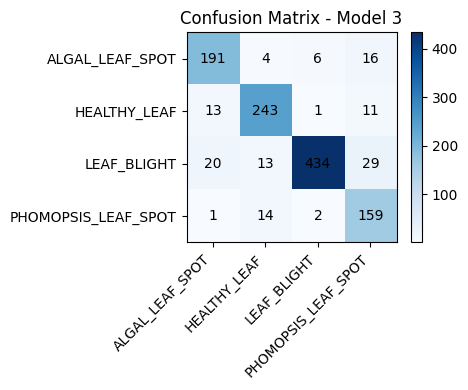

In [ ]:

# 8) รายงานเชิงคลาส + Confusion Matrix
from sklearn.metrics import classification_report, confusion_matrix
pred_probs_3 = best_3.predict(valid_data_3, verbose=1)
y_pred_3 = np.argmax(pred_probs_3, axis=1)
y_true_3 = valid_data_3.classes
idx2name_3 = {v:k for k,v in train_data_3.class_indices.items()}
target_names_3 = [idx2name_3[i] for i in range(NUM_CLASSES_3)]

print(classification_report(y_true_3, y_pred_3, target_names=target_names_3, digits=4))

cm_3 = confusion_matrix(y_true_3, y_pred_3)
plt.figure(figsize=(5,4))
plt.imshow(cm_3, cmap="Blues"); plt.title("Confusion Matrix - Model 3"); plt.colorbar()
plt.xticks(range(NUM_CLASSES_3), target_names_3, rotation=45, ha="right")
plt.yticks(range(NUM_CLASSES_3), target_names_3)
for i in range(NUM_CLASSES_3):
    for j in range(NUM_CLASSES_3):
        plt.text(j, i, cm_3[i, j], ha="center", va="center")
plt.tight_layout(); plt.show()

ตรวจสอบความพึงพอใจในคำตอบ

เริ่มทำหน้าเว็บ และ เอา model ที่ใส่ไป

เขียนการพัฒนามาด้วย
